Hackalytics.io GT Machine Learning Training in Python

0.006697540671114055
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]


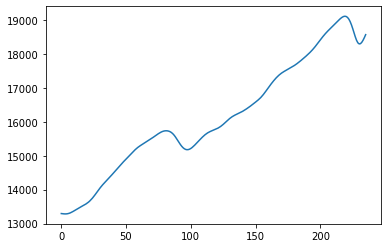

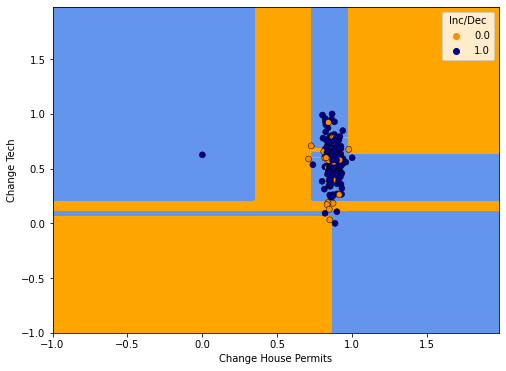

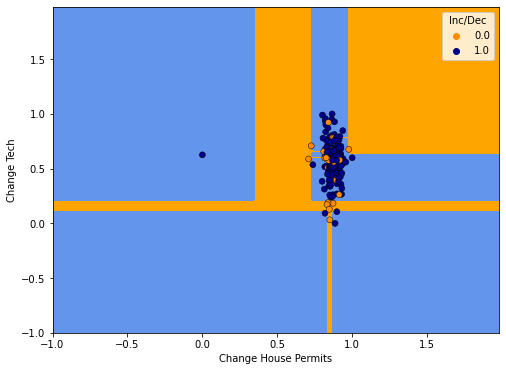

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import tree, datasets
from sklearn import preprocessing
from scipy import signal
import pickle

from sklearn.linear_model import LinearRegression

# Determines what data is stored
raw = pd.read_csv("FullData.csv")
Labels = ["Change House Permits", "Money Stock", "Change Money Stock", "Percent Savings", "Change Percent Savings", "Unemployment Rate", "Change Unemployment Rate", 
          "Change Durable Goods", "Change Non Defense", "Change Machinery", "Change stocks", "GDP", "Inc/Dec", "USD", "Change Tech", "Change Vehicle",
          "Consumer Confidence", "Change Consumer Confidence", "Business Confidence", "Change Business Confidence", "Change Gold"]

# Initializeds data preprocessing
min_max = preprocessing.MinMaxScaler()
data = min_max.fit_transform(raw[Labels].values)
data = pd.DataFrame(data, columns=Labels)

# Subsamples stock data
incompatible_data = pd.read_csv("IncompatibleData.csv")
incompatible_data = min_max.fit_transform(incompatible_data.values)
incompatible_data = pd.DataFrame(incompatible_data, columns=["Stocks", "Volume"])
incompatible_data = pd.DataFrame(incompatible_data[::21].reset_index()[0:236][["Stocks", "Volume"]])
data = pd.concat([data, incompatible_data], axis=1)

# Smoothens training data for regression
a,b = signal.butter(2, 18, 'lp', fs=350)
plt.plot(signal.filtfilt(a,b, raw["GDP"]))
raw["GDP"] = signal.filtfilt(a,b, raw["GDP"])
temp = raw.loc[1:len(raw["GDP"])+1, "GDP"].reset_index(drop = True) - raw.loc[0:len(raw["GDP"]), "GDP"]
raw["Change GDP"] = pd.Series([0]).append(pd.Series(temp)).reset_index(drop = True)[0:len(temp)]

# Choose targets
test1 = "Change House Permits"
test2 = "Change Tech"
test3 = "Change stocks"
target1 = "Inc/Dec"
target2 = "Change GDP"

# Training sets
X = data[[test1, test2]]
Y = data[target1]
X1 = pd.DataFrame(data[test3])
Y1 = raw[target2]

#Training
reg = LinearRegression().fit(X1, Y1)
print(reg.score(X1,Y1))
W = reg.predict(X1)
pred = pd.concat([raw["DATE"], pd.DataFrame(W, columns = ["Predict"])], axis = 1)

# Stores predictions
outfile = open("Training/Stocks.pkl",'wb')
pickle.dump(pred,outfile)
outfile.close()

# Sets constants
h = .02  # step size in the mesh
n_neighbors = 15

# Create color maps
cmap_light = ListedColormap(['orange', 'cornflowerblue'])
cmap_bold = ['darkorange', 'darkblue']

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = tree.DecisionTreeClassifier()
    clf.fit(X, Y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[test1].min() - 1, X[test1].max() + 1
    y_min, y_max = X[test2].min() - 1, X[test2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    print(Z)
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    sns.scatterplot(x=X[test1], y=X[test2], hue=Y,
                    palette=cmap_bold, alpha=1.0, edgecolor="black")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

plt.show()